In [1]:
%matplotlib inline

In [2]:
import ipywidgets
import matplotlib.collections as mplcollections
import matplotlib.patches as mplpatches
import matplotlib.pyplot as plt
import numpy as np
import sklearn.metrics
import sklearn.model_selection
import sklearn.neural_network
import skimage.color
import skimage.feature
import skimage.filters
import skimage.transform
import skvideo.io

In [3]:
np.random.seed(1234)

### Pre-process the images

In [4]:
def preprocess_frame(img):
    box = [450, 450, 1000, 150]
    frame = skimage.color.rgb2gray(img)
    return frame[box[1]:box[1] + box[3], box[0]:box[0] + box[2]]


def extract_circles(img, nboxes=10, buffer=5):
    min_circle_radius = 8
    max_circle_radius = 15
    hough_radii = np.arange(min_circle_radius, max_circle_radius, 1)
    
    edges = skimage.feature.canny(frame_, sigma=3)
    hough_res = skimage.transform.hough_circle(edges, hough_radii)
    _, cx, cy, radii = skimage.transform.hough_circle_peaks(hough_res, hough_radii, total_num_peaks=nboxes)

    cx = np.array(cx) - max_circle_radius
    cy = np.array(cy) - max_circle_radius
    radii = np.full(10, max_circle_radius * 2)
    
    cboxes = np.c_[cy, cx, radii, radii]
    cboxes[cboxes < 0] = 0
    cboxes[:, :2] -= buffer
    cboxes[:, 2:] += (buffer * 2)
    
    return cboxes


def extract_random(img, nboxes=10, buffer=5):
    m, n = img.shape
    radius = 15 * 2 + buffer * 2
    cboxes = np.zeros((nboxes, 4), dtype=np.int64)
    for i in range(nboxes):
        cx = np.random.randint(0, m - radius)
        cy = np.random.randint(0, n - radius)
        cboxes[i] = [cx, cy, radius, radius]
    return cboxes

In [5]:
nframes = 10
nboxes_per_frame = 10
box_buffer = 0

video = skvideo.io.vreader('data/videos/1-microlitre.mp4')
X = []; y = []
for i, frame in enumerate(video):
    frame_ = preprocess_frame(frame)
    
    cboxes_circle = extract_circles(frame_, nboxes=nboxes_per_frame, buffer=box_buffer)
    for x_, y_, r_x, r_y in cboxes_circle:
        box = frame_[x_:x_+r_x, y_:y_+r_y].flatten()
        X.append(box)
        y.append(1)
        
    cboxes_random = extract_random(frame_, nboxes=nboxes_per_frame, buffer=box_buffer)
    for x_, y_, r_x, r_y in cboxes_random:
        
        # Little filter to exclude anything with a full dot --- radius 15 is max we accept
        ignore = False
        for a in range(16):
            for b in range(16):
                combinations = [[x_ - a, y_ - b], [x_ + a, y_ - b], [x_ - a, y_ + b], [x_ + a, y_ + b]]
                if any(combo in cboxes_circle[:, :2].tolist() for combo in combinations):
                    ignore = True
                    
        if ignore:
            continue
        else:
            box = frame_[x_:x_+r_x, y_:y_+r_y].flatten()
            X.append(box)
            y.append(0)
        
    if i >= nframes:
        del video
        break

X = np.array(X, dtype=np.float64)
y = np.array(y, dtype=np.uint8)
assert X.shape[0] == y.shape[0]

In [6]:
n = int(np.sqrt(X.shape[1]))

def plot(sample):
    plt.imshow(X[sample].reshape(n, n), cmap='gray')
    return 'y index %d is class %d' % (sample, y[sample])


ipywidgets.interact(plot, sample=ipywidgets.IntSlider(min=0, max=X.shape[0]-1, value=0))

interactive(children=(IntSlider(value=0, description='sample', max=211), Output()), _dom_classes=('widget-inte…

<function __main__.plot(sample)>

### Build the NN classification model

In [7]:
print('Class 0 with %d samples; class 1 with %d samples' % (y[y==0].shape[0], y[y==1].shape[0]))

Class 0 with 102 samples; class 1 with 110 samples


In [8]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X, y, test_size=0.3, shuffle=True, random_state=42
)

In [9]:
model = sklearn.neural_network.MLPClassifier(
    solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(50, 50, 20), random_state=42
)
model.fit(X_train, y_train)

MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(50, 50, 20), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=42, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [10]:
y_pred = model.predict(X_test)

print("Accuracy of model is: %.2f" % sklearn.metrics.accuracy_score(y_test, y_pred))

Accuracy of model is: 1.00


## Attempt new prediction

In [39]:
box_size = int(np.sqrt(X.shape[1]))
step = 5

video = skvideo.io.vreader('data/videos/5-microlitre.mp4')

boxes = []

for frame in video:
    frame_ = preprocess_frame(frame)
    
    for m in range(0, frame_.shape[0] - box_size, step):
        for n in range(0, frame_.shape[1] - box_size, step):
            
            cbox = np.array(frame_[m:m+box_size, n:n+box_size]).flatten()
            prediction = model.predict([cbox])[0]
            if prediction == 1:
                boxes.append(cbox)
    
    print('Terminating early to avoid computational complexity')
    raise

Terminating early to avoid computational complexity


RuntimeError: No active exception to reraise

In [40]:
B = np.array(boxes)

n = int(np.sqrt(B.shape[1]))

def plot(sample):
    plt.imshow(B[sample].reshape(n, n), cmap='gray')


ipywidgets.interact(plot, sample=ipywidgets.IntSlider(min=0, max=B.shape[0]-1, value=0))

interactive(children=(IntSlider(value=0, description='sample', max=17), Output()), _dom_classes=('widget-inter…

<function __main__.plot(sample)>

### Convert detected droplets to actual area

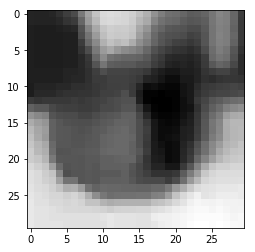

In [42]:
img = B[12].reshape(n, n)
plt.imshow(img, cmap='gray')

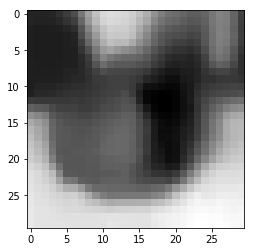

In [48]:
blurred = skimage.filters.gaussian(img, sigma=0.5)
blurred[blurred > 0.70] = 1.0
plt.imshow(blurred, cmap='gray')

In [36]:
A = blurred[blurred > 0.70].size
r = np.sqrt(A / np.pi)
print('Area=%d  r=%.2f  d=%.2f' %(A, r, r*2))

Area=592  r=13.73  d=27.45
